# MCMC para aproximación de factores en GR​
Fernanda González, Jesús Sayes

Importante: Idealmente ejecutar el codigo de seguido una celda tras otra ya que muchas variables se van sobreescribiendo en la marcha.

## Librerias y datos generales

In [16]:
# librerias a utilizar

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle, CartesianDifferential, CartesianRepresentation, FK5, Galactic
from astropy.time import Time
from IPython.display import display, Math
import random
from sympy import symbols, Eq, solve

In [2]:
# datos para S2
# estos datos se utilizaran principalmente en la parte de trayectorias relativistas

ra = 359.94425987 *u.deg  # Ascensión recta en grados
dec = -0.04616238 *u.deg # Declinación en grados
vx = -177.4 * u.km/u.s   # velocidad en x en km/s
vy = 14.5 * u.km/u.s     # velocidad en y en km/s
d = 12.562 * u.parsec    # distancia de la tierra a s2 (para el cambio de unidades)

# constantes universales
ce = 299792458
G = 6.6743e-11
M = 1.98840987e+30 * 19.5


# para pasar las velocidades cartecianas a velocidades angulares
pm_ra_cosdec = (vx / d.to(u.km)).to(u.mas/u.yr, equivalencies=u.dimensionless_angles())
pm_dec = (vy / d.to(u.km)).to(u.mas/u.yr, equivalencies=u.dimensionless_angles())

# Crea el Skycoord de los datos de posicion y velocidades
c = SkyCoord(ra=ra, dec=dec, frame='icrs', pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec)

# printear los datos del sistema
print(c.galactic)

<SkyCoord (Galactic): (l, b) in deg
    (96.19736567, -60.20861016)
 (pm_l_cosb, pm_b) in mas / yr
    (-2632.3505947, 1415.83126442)>


## Trayectoria Clasica

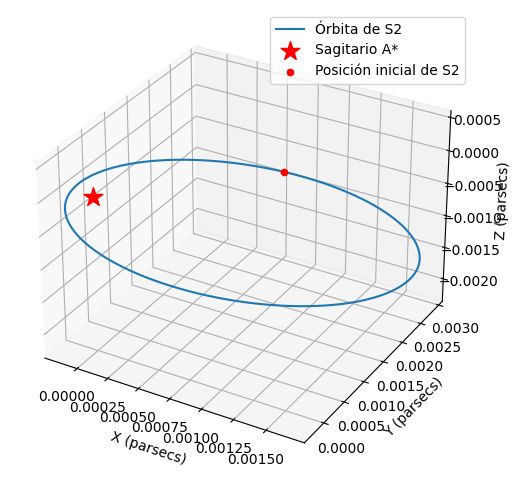

In [3]:
# modelo 3d de la trayectoria de S2

# Parámetros de la órbita de S2
a = 0.002  # Semieje mayor en parsecs
e = 0.88   # Excentricidad
omega = np.radians(150)  # Argumento del periastro en radianes
i = np.radians(60)  # Inclinación en radianes
N = 10**6 # Numero de puntos

# Generar trayectorias de la orbita con la solucion clasica del sistema
theta = np.linspace(0, 2 * np.pi, N)
r = a * (1 - e**2) / (1 + e * np.cos(theta - omega))

# pasamos el sistema a cartesianas
x_orbit = r * np.cos(theta)
y_orbit = r * np.sin(theta)

x = x_orbit * np.cos(i)
y = x_orbit * np.sin(i)
z = y_orbit

# agregamos SgA* al grafico y la posicion inicial de S2
sgr_a_pos = np.array([0, 0, 0])
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Órbita de S2')
ax.scatter(*sgr_a_pos, color='red', marker='*', s=200, label='Sagitario A*')
ax.scatter([x[0]], [y[0]], [z[0]], color='red', label='Posición inicial de S2')
ax.set_xlabel('X (parsecs)')
ax.set_ylabel('Y (parsecs)')
ax.set_zlabel('Z (parsecs)')
ax.legend()
plt.show()

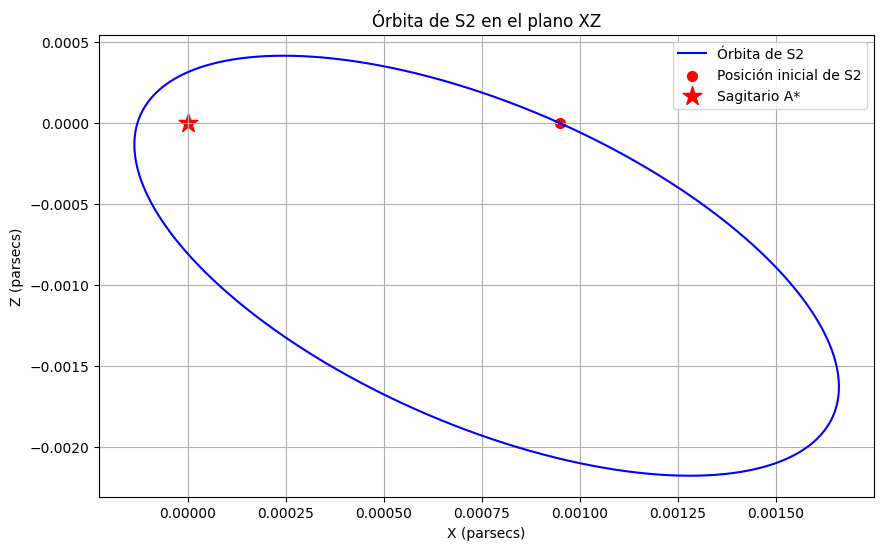

In [4]:
# trayectoria de S2 en 2D XZ


plt.figure(figsize=(10, 6))
plt.plot(x, z, label='Órbita de S2', color='blue')
plt.scatter([x[0]], [z[0]], color='red', label='Posición inicial de S2', s=50)
plt.scatter(0,0, color='red', marker='*', s=200, label='Sagitario A*')
plt.xlabel('X (parsecs)')
plt.ylabel('Z (parsecs)')   # nos centramos en el plano XZ pues es donde se dibuja la orbita
plt.title('Órbita de S2 en el plano XZ')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Trayectorias 2D de S1 a S6
# repetimos lo anterior ahora para 6 estrellas


# Parámetros de las órbitas de S1 a S6
a_s1 = 0.0015
e_s1 = 0.75
omega_s1 = np.radians(120)
i_s1 = np.radians(45)

a_s2 = 0.002
e_s2 = 0.88
omega_s2 = np.radians(150)
i_s2 = np.radians(60)

a_s3 = 0.0022
e_s3 = 0.9
omega_s3 = np.radians(170)
i_s3 = np.radians(65)

a_s4 = 0.0017
e_s4 = 0.8
omega_s4 = np.radians(200)
i_s4 = np.radians(50)

a_s5 = 0.0018
e_s5 = 0.82
omega_s5 = np.radians(240)
i_s5 = np.radians(55)

a_s6 = 0.0023
e_s6 = 0.92
omega_s6 = np.radians(280)
i_s6 = np.radians(70)

# Genera las trayectorias
theta = np.linspace(0, 2 * np.pi, 10**4)

r_s2 = a_s2 * (1 - e_s2**2) / (1 + e_s2 * np.cos(theta - omega_s2))
r_s1 = a_s1 * (1 - e_s1**2) / (1 + e_s1 * np.cos(theta - omega_s1))
r_s3 = a_s3 * (1 - e_s3**2) / (1 + e_s3 * np.cos(theta - omega_s3))
r_s4 = a_s4 * (1 - e_s4**2) / (1 + e_s4 * np.cos(theta - omega_s4))
r_s5 = a_s5 * (1 - e_s5**2) / (1 + e_s5 * np.cos(theta - omega_s5))
r_s6 = a_s6 * (1 - e_s6**2) / (1 + e_s6 * np.cos(theta - omega_s6))

# Pasamos al plano cartesiano
x_s1 = r_s1 * np.cos(theta)
z_s1 = r_s1 * np.sin(theta)

x_s2 = r_s2 * np.cos(theta)
z_s2 = r_s2 * np.sin(theta)

x_s3 = r_s3 * np.cos(theta)
z_s3 = r_s3 * np.sin(theta)

x_s4 = r_s4 * np.cos(theta)
z_s4 = r_s4 * np.sin(theta)

x_s5 = r_s5 * np.cos(theta)
z_s5 = r_s5 * np.sin(theta)

x_s6 = r_s6 * np.cos(theta)
z_s6 = r_s6 * np.sin(theta)



x_s1_3d = x_s1 * np.cos(i_s1) * 10
z_s1_3d = z_s1 * 10

x_s2_3d = x_s2 * np.cos(i_s2) * 10
z_s2_3d = z_s2 * 10

x_s3_3d = x_s3 * np.cos(i_s3) * 10
z_s3_3d = z_s3 * 10

x_s4_3d = x_s4 * np.cos(i_s4) * 10
z_s4_3d = z_s4 * 10

x_s5_3d = x_s5 * np.cos(i_s5) * 10
z_s5_3d = z_s5 * 10

x_s6_3d = x_s6 * np.cos(i_s6) * 10
z_s6_3d = z_s6 * 10



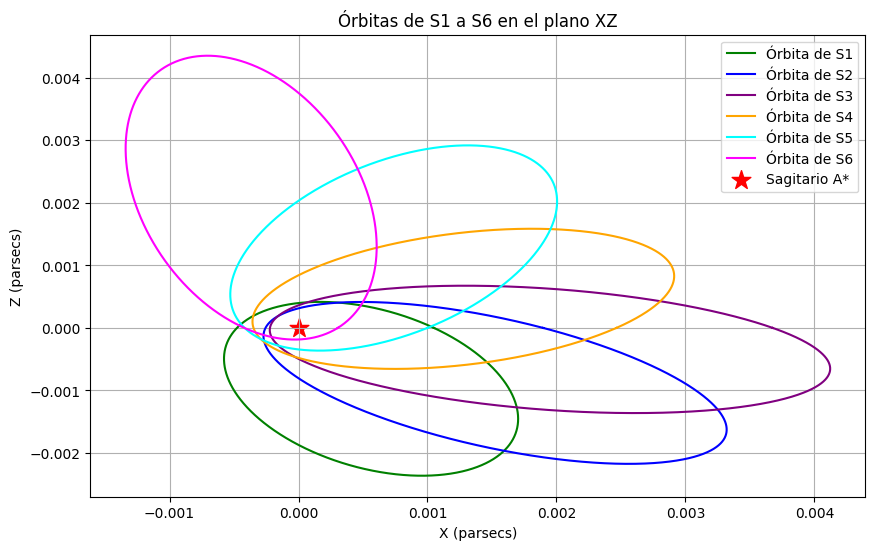

In [6]:
# Graficos

plt.figure(figsize=(10, 6))
plt.plot(x_s1, z_s1, label='Órbita de S1', color='green')
plt.plot(x_s2, z_s2, label='Órbita de S2', color='blue')
plt.plot(x_s3, z_s3, label='Órbita de S3', color='purple')
plt.plot(x_s4, z_s4, label='Órbita de S4', color='orange')
plt.plot(x_s5, z_s5, label='Órbita de S5', color='cyan')
plt.plot(x_s6, z_s6, label='Órbita de S6', color='magenta')
plt.scatter(0, 0, color='red', marker='*', s=200, label='Sagitario A*')
plt.xlabel('X (parsecs)')
plt.ylabel('Z (parsecs)')
plt.title('Órbitas de S1 a S6 en el plano XZ')
plt.legend()
plt.grid(True)
plt.show()


## Trayectoria GR

In [7]:
# datos para S2

ra = 359.94425987 *u.deg  # Ascensión recta en grados
dec = -0.04616238 *u.deg # Declinación en grados
vx = -177.4 * u.km/u.s  # velocidad cartesiana en x
vy = 14.5 * u.km/u.s    # velocidad cartesiana en y
d = 12.562 * u.parsec   # distancia de la tierra a s2

# constantes universales
ce = 299792458
G = 6.6743e-11
M = 1.98840987e+30 * 19.5


# para pasar a velocidades angulares
pm_ra_cosdec = (vx / d.to(u.km)).to(u.mas/u.yr, equivalencies=u.dimensionless_angles())
pm_dec = (vy / d.to(u.km)).to(u.mas/u.yr, equivalencies=u.dimensionless_angles())

# Crea el Skycoord de la posicion
coord = SkyCoord(ra=ra, dec=dec, frame='icrs', pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec, obstime='J2000')

# Imprime las coordenadas en el sistema galáctico
print(c.galactic)

<SkyCoord (Galactic): (l, b) in deg
    (96.19736567, -60.20861016)
 (pm_l_cosb, pm_b) in mas / yr
    (-2632.3505947, 1415.83126442)>


/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


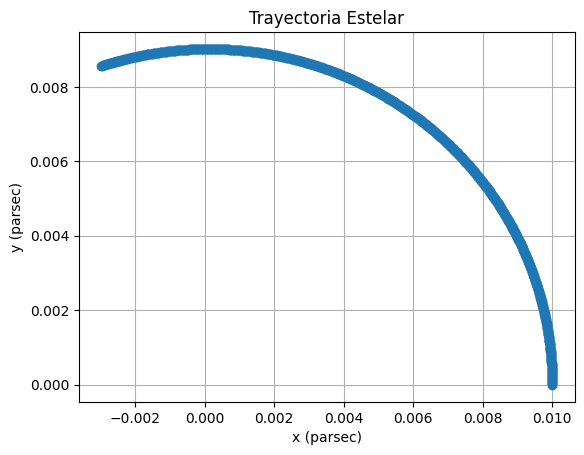

In [8]:
# Definir un rango de años para seguir la trayectoria y la lista de posiciones
years = np.arange(2000, 10**4, 10)
positions = []

# Calcular la posición en cada año y almacenarla en la lista
for year in years:
    time = Time(f'{year}-01-01T00:00:00')   # creamos un tiempo
    current_position = coord.apply_space_motion(time)   # generamos la nueva coordenada luego del tiempo dado
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)      # la guardamos

# Extraer las coordenadas y convertirlas a cartesianas para graficar
ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]

x = []
y = []
z = []

for i in range(len(ra_values)):
  # para cada dato lo pasamos a skycoord para calcular sus componentes cartesianas
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2 #reescalado
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

plt.plot(x, y, marker='o')
plt.xlabel('x (parsec)')
plt.ylabel('y (parsec)')
plt.title('Trayectoria Estelar')
plt.grid(True)
plt.show()

# el grafico muestra la trayectoria en solo unos instantes de tiempo,
# esto debido a que el formato en que se agrega el tiempo es muy reestrictivo
# y solo acepta numeros de 4 digitos

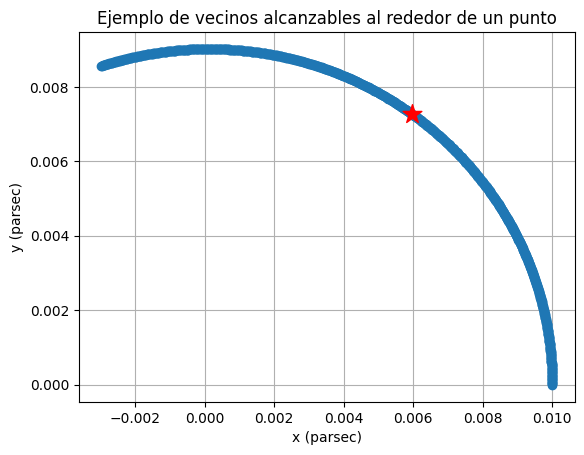

In [9]:
# dado un punto de la trayectoria el limite alcanzable que permite skycoord es es de 9000 yr,
# para los vecinos se definira la posicion vase en 5000 y sus vecinos estaran en el intervalo [1000,9000]

plt.plot(x, y, marker='o')
plt.scatter(x[len(years)//2], y[len(years)//2], color='red', marker='*', s=200, label='Sgr A*', zorder=10)
plt.xlabel('x (parsec)')
plt.ylabel('y (parsec)')
plt.title('Ejemplo de vecinos alcanzables al rededor de un punto')
plt.grid(True)
plt.show()

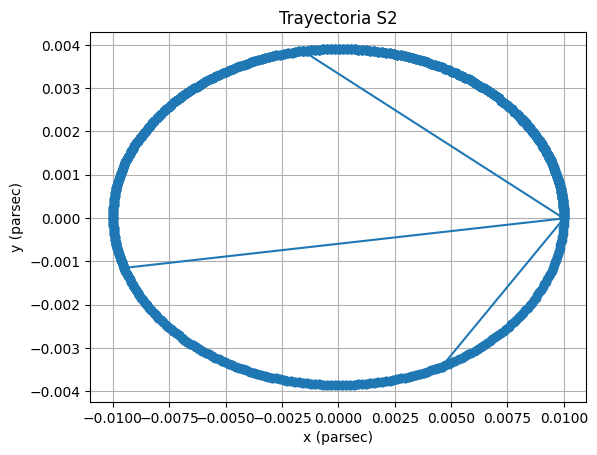

In [10]:
# generamos ahora la trayectoria completa

paralelaje = 0.0031 * u.deg # esto permite correguir un poco la trayectoria

pm_ra = (-177.4 * u.km/u.s /d *paralelaje).to(u.mas/u.yr)  # Velocidad propia en ascensión recta
pm_dec = (14.5 * u.km/u.s /d *paralelaje).to(u.mas/u.yr)  # Velocidad propia en declinación


# para crear la trayectoria completa generamos varias de distintos trozos y las unimos
# esto es repetir el codigo anterior varias veces


initial_position = SkyCoord(ra=ra, dec=dec, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
years = np.linspace(2000,9000,100,dtype=int)
positions = []

for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)
ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


x = []
y = []
z = []
for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

ra = ra_values[-1]
dec = dec_values[-1]
pm_ra = pm_ra_values[-1]
pm_dec = pm_dec_values[-1]

initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)
ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

ra = ra_values[-1]
dec = dec_values[-1]
pm_ra = pm_ra_values[-1]
pm_dec = pm_dec_values[-1]

initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)
ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

ra = ra_values[-1]
dec = dec_values[-1]
pm_ra = pm_ra_values[-1]
pm_dec = pm_dec_values[-1]

initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)

ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)


plt.plot(x, z, marker='o')
plt.plot(x[0],z[0])
plt.xlabel('x (parsec)')
plt.ylabel('y (parsec)')
plt.title('Trayectoria S2')
plt.grid(True)
plt.show()

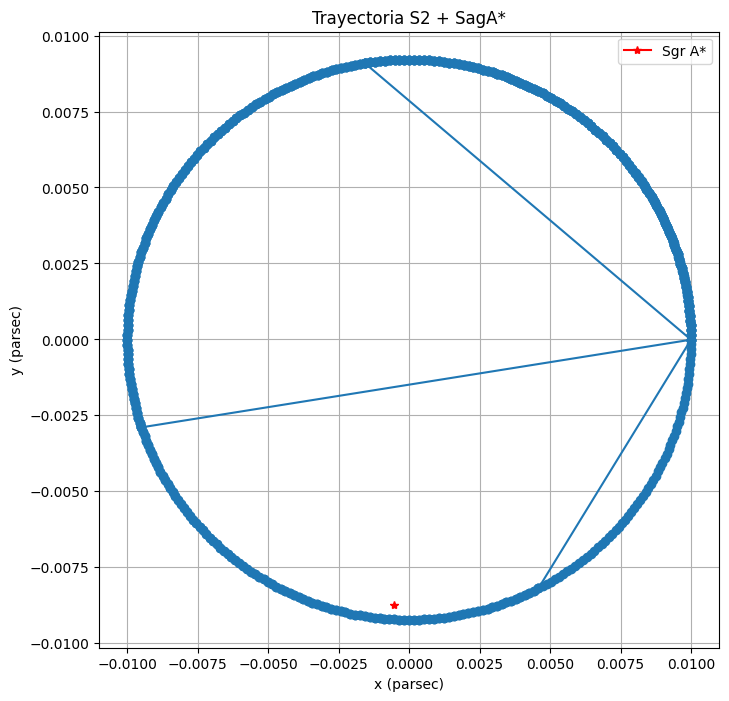

In [11]:
# agregamos Sagitario A* al grafico

# Coordenadas de Sagitario A* en grados
sgr_a_star_coord = SkyCoord(ra=266.41683 * u.deg, dec=-29.00781 * u.deg, frame='icrs')

# Convertir coordenadas esféricas a cartesianas
x_sag = sgr_a_star_coord.cartesian.x * 1e-2 # reescalado
y_sag = sgr_a_star_coord.cartesian.y * 1e-2
z_sag = sgr_a_star_coord.cartesian.z * 1e-2

# Graficar la posición de Sagittarius A* en coordenadas cartesianas
plt.figure(figsize=(8, 8))
plt.plot(x, y, marker='o')
plt.plot(x[0],y[0])
plt.plot(x_sag, y_sag, color='red', marker='*', label='Sgr A*')
plt.xlabel('x (parsec)')
plt.ylabel('y (parsec)')
plt.title('Trayectoria S2 + SagA*')
plt.grid(True)
plt.legend()
plt.show()

## Metodo MCMC

In [23]:
# funciones


coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J5000')

# funcion chi que se busca minimizar
def chi(coord,x_cl,y_cl):
  # obtenemos las componentes cartesianas de la coordenada dada
  x0_GR = coord.cartesian.x.value
  y0_GR = coord.cartesian.y.value
  s = 0
  # suma sobre los puntos de la trayectoria
  for i in range(1,len(x_cl)):
    s += ((x_cl[i] - x0_GR)/(x_cl[i] - x_cl[i-1]))**2
  for j in range(1,len(y_cl)):
    s += ((y_cl[j] - y0_GR)/(y_cl[j]- y_cl[j-1]))**2
  return s * 3.24078e-17    # retorna la suma y cambia sus unidades


print(coord)
print(chi(coord,x_s2,z_s2))

# funcion que dado un punto genera un vecino de este a travez de la trayectoria relativista
def vecino(x_cl,y_cl,coord):
  num = random.randint(1000,9000)   # punto uniforme en el intervalor [1000,9000] (nuestra posicion inicial corresponde a 5000)
  year = num
  time = Time(f'{year}-01-01T00:00:00')   # generamos la variable de tiempo
  coord = coord.apply_space_motion(time)  # movemos la coord inicial en el time que se genero aleatoriamente

  # recuperamos las componentes radiales para volver a crear una trayectoria
  ra = coord.ra.deg
  dec = coord.dec.deg
  pm_ra = coord.pm_ra_cosdec
  pm_dec = coord.pm_dec
  # creamos la trayectoria centrada en el tiempo 5000
  coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J5000')
  # entregamos la nueva coordenada
  return coord

coord = vecino(x_s2, z_s2,coord)
print(coord)
print(chi(coord,x_s2,z_s2))


<SkyCoord (ICRS): (ra, dec) in deg
    (200.2543064, -14.81610649)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.02361639, 0.01099411)>
4153588.8976095314
<SkyCoord (ICRS): (ra, dec) in deg
    (200.25431375, -14.8161098)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.02361639, 0.01099411)>
4153588.3791428907


/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [24]:
def MCMC(coord, x , y , beta,  n):
  # calculamos la chi del estado inicial
  h0 = chi(coord,x,y)
  # generamos n uniformes entre 0 y 1
  u = np.random.uniform(0, 1, n)
  # para cada una de las iteraciones n indicadas
  for i in range(n):
    # creamos un veciono de la coord actual
    new_coord = vecino(x,y,coord)
    # calculamos el chi del vecino
    h1 = chi(new_coord,x,y)
    # calculamos la constante
    # en caso h0 > h1 entonces siempre sera 1 y siempre se aceptara
    cte = min(1.0, np.exp(-beta * (h0 - h1)))
    if u[i] <= cte:
      # de aceptar tendremos una nueva coordenada con un nuevo chi
      coord = new_coord
      h0 = h1
    # en caso h0 < h1 si la probabilidad logra caer en el intervalo
  # entregamos la nueva coordenada y su respectivo chi
  return [coord,h0]

coord , h0 = MCMC(coord , x_s2 , z_s2 , 0.1 , 10**4)

print(coord)
print(h0)

<SkyCoord (ICRS): (ra, dec) in deg
    (200.24680902, -14.81273212)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.02361602, 0.0109949)>
4154118.2500891904


## Obtener la cota

In [27]:
# a partir del punto encontrado recuperemos sus posiciones y velocidades en cartesianas

coordenadas_galacticas = coord.transform_to(Galactic)
velocidades_galacticas_masyr = coordenadas_galacticas.velocity.d_xyz
distancia_pc = 12.562

# Convertir velocidades angulares a velocidades lineales en km/s
constante_conversion = (distancia_pc * u.pc).to(u.km)
velocidades_lineales_kmps = (velocidades_galacticas_masyr * constante_conversion).to(u.km/u.s)
coordenadas_cartesianas = coordenadas_galacticas.represent_as(CartesianRepresentation)
velocidades_cartesianas = CartesianDifferential(velocidades_lineales_kmps)

coordenadas_lista = list(coordenadas_cartesianas.xyz.value)
velocidades_lista = list(velocidades_cartesianas.d_xyz.value)

# Mostrar las velocidades cartesianas
print("Coordenadas cartesianas:", coordenadas_cartesianas)
print("Velocidades cartesianas en km/s:", velocidades_cartesianas)


Coordenadas cartesianas: (0.46569197, -0.49032237, 0.73669191) 
Velocidades cartesianas en km/s: (-0.00137278, -0.0004064, 0.0005973) km / s


In [28]:
# resolver la ecuacion para beta y lambda

# Definir las variables simbólicas
beta, lambd = symbols('beta lambd')

# constantes universales de las ecuaciones
G = 6.6743e-11
ce = 299792458
M = 1.98840987e+30 * 19.5

# posiciones y velocidades de la celda anterior

x = coordenadas_lista[0] * 3.086e+16      # el 3.086e+16 es para pasar de parsec a metros
y = coordenadas_lista[1] * 3.086e+16
vx = velocidades_lista[0] * 1000        # el 1000 es para pasar de km a m
vy = velocidades_lista[1] * 1000
r = np.sqrt(x**2 + y**2)
v = np.sqrt(vx**2 + vy**2)


# generamos las aceleraciones clasicas y las corregimos
ax_clasica = -G*M*x/(r**3)
ax = ax_clasica * 1.1999999999955415
ay_clasica = -G*M*y/(r**3)
ay = ay_clasica * 1.1999999999955422


# Definir las ecuaciones del sistema
ecuacion1 = Eq(-G*M*x/(r**3) +
               G*M/(ce**2 * r**4)*(x*(4*G*M + r*(3*vx**2 - vy**2)) + 4*r*vx*vy*y) + beta * 2*G*M*x/(ce**2 * r**4)*(r*(v**2 - ce**2) + 2*G*M) -
               4*G*lambd*M**2/(r**8) * (G*M*r*x + 2*(vx*x+vy*y) * (vx*(x**2 - 2*y**2) + 3*vy*x*y)),
               ax)
ecuacion2 = Eq(-G*M*y/(r**3) + G*M/(ce**2 * r**4)*(y*(4*G*M + r*(3*vy**2 - vx**2)) + 4*r*vx*vy*x) + beta * 2*G*M*y/(ce**2 * r**4)*(r*(v**2 - ce**2) + 2*G*M) -
               4*G*lambd*M**2/(r**8) * (G*M*r*y + 2*(vx*x+vy*y) * (vy*(y**2 - 2*x**2) + 3*vx*x*y)),
               ay)

# Resolver el sistema de ecuaciones
solucion = solve((ecuacion1, ecuacion2), (beta, lambd))

# Mostrar la solución
print("La solución del sistema de ecuaciones es:", solucion)

La solución del sistema de ecuaciones es: {beta: 0.100000000003782, lambd: -2.81173873333953}


De aqui el paper original planteaba los valores $\beta = 0.1$ y $\lambda = 0.01$ (mas especificamente $\beta^2= 0.1$, $\frac{1}{\lambda^4} = 0.01$, en este caso los usaremos sin exponentes y sin invertir el $\lambda$).

## Otras trayectorias

In [29]:
# haremos el mismo proceso de minimizacion para s6

# Parámetros iniciales
ra = '17h45m40.04s'
dec = '-29d00m40.9s'
vx = -176.4  * u.km/u.s
vy = 15.5 * u.km/u.s
d = 875.96018 * u.parsec
ra = Angle(ra).deg
dec = Angle(dec).deg
paralelaje = 0.035 * u.deg
pm_ra = (vx  /d *paralelaje).to(u.mas/u.yr)
pm_dec = (vy  /d *paralelaje).to(u.mas/u.yr)

# Creacion del SkyCoord
initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
years = np.linspace(2000,9000,100,dtype=int)
positions = []

for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)

ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]

x = []
y = []
z = []
for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

ra = ra_values[-1]
dec = dec_values[-1]
pm_ra = pm_ra_values[-1]
pm_dec = pm_dec_values[-1]

initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)

ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

ra = ra_values[-1]
dec = dec_values[-1]
pm_ra = pm_ra_values[-1]
pm_dec = pm_dec_values[-1]

initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)

ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)

ra = ra_values[-1]
dec = dec_values[-1]
pm_ra = pm_ra_values[-1]
pm_dec = pm_dec_values[-1]

initial_position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J2000')
for year in years:
    time = Time(f'{year}-01-01T00:00:00')
    current_position = initial_position.apply_space_motion(time)
    current_position = current_position.transform_to(FK5(equinox=time))
    positions.append(current_position)

ra_values = [pos.ra.deg for pos in positions]
dec_values = [pos.dec.deg for pos in positions]
pm_ra_values = [pos.pm_ra_cosdec for pos in positions]
pm_dec_values = [pos.pm_dec for pos in positions]


for i in range(len(ra_values)):
  c = SkyCoord(ra=ra_values[i]*u.deg, dec=dec_values[i]*u.deg, frame='icrs', pm_ra_cosdec=pm_ra_values[i].value*u.mas/u.yr, pm_dec=pm_dec_values[i].value*u.mas/u.yr)
  x_cartesian = c.cartesian.x.value * 1e-2
  y_cartesian = c.cartesian.y.value * 1e-2
  z_cartesian = c.cartesian.z.value * 1e-2
  x.append(x_cartesian)
  y.append(y_cartesian)
  z.append(z_cartesian)


/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


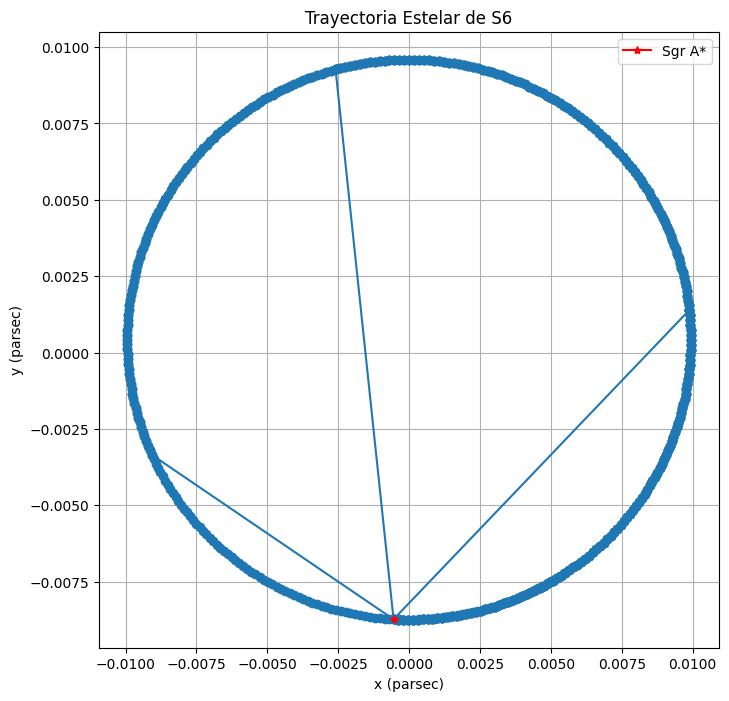

In [30]:
# Graficar S6 junto a la posición de Sagitario A* en coordenadas cartesianas
plt.figure(figsize=(8, 8))
plt.plot(x, y, marker='o')
plt.plot(x[0],y[0])
plt.plot(x_sag, y_sag, color='red', marker='*', label='Sgr A*')
plt.xlabel('x (parsec)')
plt.ylabel('y (parsec)')
plt.title('Trayectoria Estelar de S6')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
# aplicamos mcmc a la trayectoria
coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs', pm_ra_cosdec=pm_ra, pm_dec=pm_dec, obstime='J5000')
coord , h0 = MCMC(coord , x_s6 , z_s6 , 50 , 10**4)
print(coord)
print(h0)

<SkyCoord (ICRS): (ra, dec) in deg
    (200.30989444, -14.84111437)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.02361912, 0.01098825)>
25469.12338481761


In [32]:
# recuperamos la pocision y velocidades en cartesianas

coordenadas_galacticas = coord.transform_to(Galactic)
velocidades_galacticas_masyr = coordenadas_galacticas.velocity.d_xyz
distancia_pc = 12.562

constante_conversion = (distancia_pc * u.pc).to(u.km)
velocidades_lineales_kmps = (velocidades_galacticas_masyr * constante_conversion).to(u.km/u.s)

coordenadas_cartesianas = coordenadas_galacticas.represent_as(CartesianRepresentation)
velocidades_cartesianas = CartesianDifferential(velocidades_lineales_kmps)
coordenadas_lista = list(coordenadas_cartesianas.xyz.value)
velocidades_lista = list(velocidades_cartesianas.d_xyz.value)
print("Coordenadas cartesianas:", coordenadas_cartesianas)
print("Velocidades cartesianas en km/s:", velocidades_cartesianas)

Coordenadas cartesianas: (0.46673058, -0.49001446, 0.73623936) 
Velocidades cartesianas en km/s: (-0.00137193, -0.00040729, 0.00059864) km / s


In [33]:
# resolvemos el sistema

# Definir las variables simbólicas
beta, lambd = symbols('beta lambd')

# constantes
G = 6.6743e-11
ce = 299792458
M = 1.98840987e+30 * 19.5
# valores obtenidos
x = coordenadas_lista[0] * 3.086e+16      # el 3.086e+16 es para pasar de parsec a metros
y = coordenadas_lista[1] * 3.086e+16
vx = velocidades_lista[0] * 1000        # el 1000 es para pasar de km a m
vy = velocidades_lista[1] * 1000
r = np.sqrt(x**2 + y**2)
v = np.sqrt(vx**2 + vy**2)

# generamos las aceleraciones clasicas y las corregimos
ax_clasica = -G*M*x/(r**3)
ax = ax_clasica * 1.1999999999955415
ay_clasica = -G*M*y/(r**3)
ay = ay_clasica * 1.1999999999955422

# Definir las ecuaciones del sistema
ecuacion1 = Eq(-G*M*x/(r**3) +
               G*M/(ce**2 * r**4)*(x*(4*G*M + r*(3*vx**2 - vy**2)) + 4*r*vx*vy*y) + beta * 2*G*M*x/(ce**2 * r**4)*(r*(v**2 - ce**2) + 2*G*M) -
               4*G*lambd*M**2/(r**8) * (G*M*r*x + 2*(vx*x+vy*y) * (vx*(x**2 - 2*y**2) + 3*vy*x*y)),
               ax)
ecuacion2 = Eq(-G*M*y/(r**3) + G*M/(ce**2 * r**4)*(y*(4*G*M + r*(3*vy**2 - vx**2)) + 4*r*vx*vy*x) + beta * 2*G*M*y/(ce**2 * r**4)*(r*(v**2 - ce**2) + 2*G*M) -
               4*G*lambd*M**2/(r**8) * (G*M*r*y + 2*(vx*x+vy*y) * (vy*(y**2 - 2*x**2) + 3*vx*x*y)),
               ay)

# Resolver el sistema de ecuaciones
solucion = solve((ecuacion1, ecuacion2), (beta, lambd))

# Mostrar la solución
print("La solución del sistema de ecuaciones es:", solucion)

La solución del sistema de ecuaciones es: {beta: 0.100000000000071, lambd: 0.695323520893900}


Notamos que para el $\lambda$ hay casos donde se aleja mucho del valor esperado.

In [34]:
# testeamos la funcion mcmc para distintos betas o temperaturas

# beta para MCMC
betas = np.linspace(0.1, 40 , 20)
h = []
for beta in betas:
  coord , h0 = MCMC(coord , x_s6 , z_s6 , beta , 10**2)
  h.append(h0)

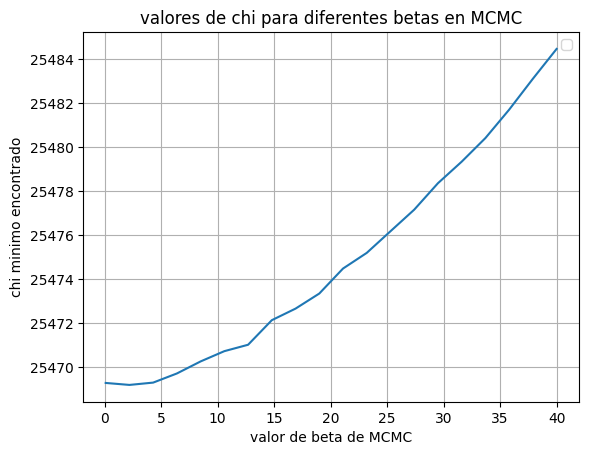

In [35]:
# los h0 para distintos betas
plt.plot(betas, h)
plt.xlabel('valor de beta de MCMC')
plt.ylabel('chi minimo encontrado')
plt.title('valores de chi para diferentes betas en MCMC')
plt.grid(True)
plt.legend()
plt.show()